In [1]:
#imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("data.csv")

In [ ]:
df['Date'] = pd.to_datetime(df['Date'],format="%d-%m-%Y")
df = df.sort_values('Date').reset_index(drop=True)

In [ ]:
def convert_volume(vol):
    if 'M' in vol:
        return float(vol.replace('M',''))*1000000
    elif 'k' in vol:
        return float(vol.replace('K',''))*1000
    else:
        return np.nan

In [ ]:
df['Volume'] = df['Vol.'].apply(convert_volume)

In [ ]:
df['Change'] = df['Change %'].str.replace('%','').astype(float) / 100

In [ ]:
df = df.drop(columns=['Vol.','Change %'])

In [ ]:
df.head()

,Date,Price,Open,High,Low,Volume,Change
0,2010-01-04,17.94,17.32,17.95,17.29,52090000.0,0.0406
1,2010-01-05,17.69,17.94,17.94,17.58,43380000.0,-0.0139
2,2010-01-06,17.63,17.69,17.83,17.55,41410000.0,-0.0034
3,2010-01-07,17.57,17.67,17.70,17.50,39430000.0,-0.0034
4,2010-01-08,17.71,17.65,17.74,17.56,30410000.0,0.0080


In [ ]:
import xgboost as xgb

In [ ]:
from xgboost import XGBClassifier

In [ ]:
import sklearn

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
df['Return'] = df['Price'].pct_change()
df['Target'] = (df['Return'].shift(-1)>0).astype(int)

In [ ]:
window = 10
df['Rollingmean'] = df['Price'].rolling(window).mean()
df['Rollingstd'] = df['Price'].rolling(window).std()
df['ZScore'] = (df['Price'] - df['Rollingmean']) / df['Rollingstd']
df['Momentum_5'] = df['Price'].pct_change(5)
df['Momentum_10'] = df['Price'].pct_change(10)
df['Bollinger_Width'] = (2 * df['Rollingstd']) / df['Rollingmean']
df['Volume_Change'] = df['Volume'].pct_change()

In [ ]:
df['avg20'] = df['Volume'].rolling(window=20).mean()
df['Volume_ratio'] = df['Volume'] / df['avg20']
df['Rank_Negreturn'] = (df['Return'].rank(ascending=True))
df['Rank_Volumeratio'] = df['Volume_ratio'].rank()
df['Hump_Alpha'] = df['Rank_Negreturn'] * df['Rank_Volumeratio']
df['Hump_Alpha'] = (df['Hump_Alpha'] - df['Hump_Alpha'].mean()) / df['Hump_Alpha'].std()


In [ ]:
df = df.dropna().reset_index(drop=True)

In [ ]:
df.head()

,Date,Price,Open,High,Low,Volume,Change,Return,Target,Rollingmean,...,ZScore,Momentum_5,Momentum_10,Bollinger_Width,Volume_Change,avg20,Volume_ratio,Rank_Negreturn,Rank_Volumeratio,Hump_Alpha
0,2010-02-01,17.81,17.81,18.00,17.73,39460000.0,0.0068,0.006783,1,18.091,...,-0.594297,-0.003358,-0.036255,0.052272,-0.295860,52714000.0,0.748568,2845.0,831.0,-0.368643
1,2010-02-02,18.24,17.89,18.32,17.79,67640000.0,0.0241,0.024144,0,18.019,...,0.598467,0.024719,-0.037975,0.040988,0.714141,53491500.0,1.264500,3698.0,3192.0,2.350048
2,2010-02-03,17.65,17.72,17.87,17.46,114000000.0,-0.0323,-0.032346,0,17.894,...,-1.114942,-0.019989,-0.066138,0.024460,0.685393,57022500.0,1.999211,57.0,3726.0,-0.988370
3,2010-02-04,17.09,17.39,17.48,17.07,94260000.0,-0.0317,-0.031728,0,17.779,...,-2.275017,-0.032276,-0.063048,0.034069,-0.173158,59665000.0,1.579821,59.0,3573.0,-0.988824
4,2010-02-05,17.03,16.98,17.24,16.68,90400000.0,-0.0035,-0.003511,0,17.685,...,-1.749416,-0.037309,-0.052309,0.042342,-0.040951,62213500.0,1.453061,1388.0,3457.0,0.332390


In [ ]:
features = ['ZScore', 'Momentum_5', 'Momentum_10', 'Bollinger_Width','Volume_Change','Hump_Alpha']

X = df[features]
y = df['Target']

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
train_mask = df['Date'] < '2022-01-01'
test_mask = df['Date'] >= '2022-01-01'

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
dates_test = df['Date'][test_mask]
prices_test = df['Price'][test_mask].values

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = XGBClassifier(
    use_label_encoder= False,
    eval_metric= 'logloss')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

/Users/mannasmshah/Desktop/Pranak_Trex_BITS/pfizer_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:47:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
positions = y_pred * 2 - 1 
returns = np.diff(prices_test) / prices_test[:-1] 
pnl = positions[:-1] * returns * 1_000_000


In [ ]:
cumulative_pnl = np.cumsum(pnl)

In [ ]:
buy_and_hold_returns = (prices_test[1:] - prices_test[0]) * 1_000_000 / prices_test[0]

In [ ]:
i = 1_000_000
portfolio_values = i + cumulative_pnl
portfolio_values = portfolio_values.reshape(1, -1)
print("Portfolio representation shape:", portfolio_values.shape)


Portfolio representation shape: (1, 824)


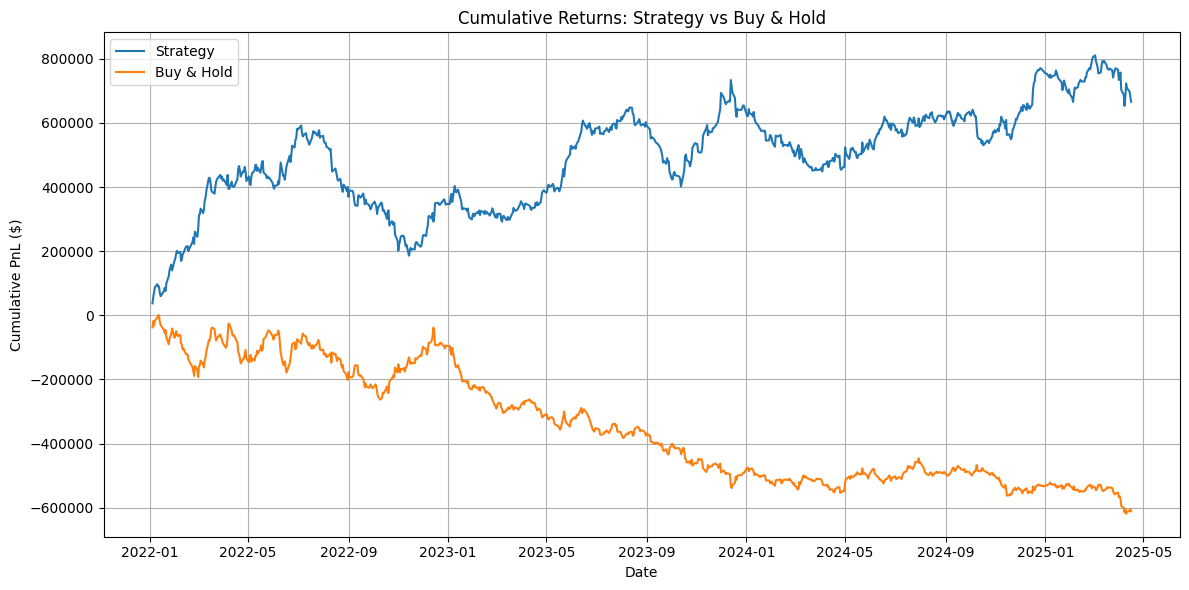

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(dates_test[1:], cumulative_pnl, label='Strategy')
plt.plot(dates_test[1:], buy_and_hold_returns, label='Buy & Hold')
plt.title("Cumulative Returns: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()